### Libraries

In [16]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz
from sklearn.model_selection import train_test_split

In [8]:
# Data Load
df = pd.read_csv('THI_CABG_DATA_2015_2020.csv')

#### Data Cleaning & Audit

In [12]:
# Missing Value Analysis and Imputation

df0 = df.copy()
df0 = df.drop(columns = ['TempSNO', 'city_id', 'Ethicity_language', 'date_of_discharge','date_of_admission', 'date_of_surgery'])
df0 = df0.replace(r'^\s*$', np.nan, regex=True)

# Variable: Process

# BMI: Imputation
df0['BMI'] = df0['weight']/((df0['height']/100)**2)

# BPsystolic: Data Type Change and Imputation
df0['BPsystolic'] = pd.to_numeric(df0['BPsystolic'],errors = 'coerce')
m1 = df0.loc[df0['hypertension'] == 1, 'BPsystolic'].mean()
m2 = df0.loc[df0['hypertension'] == 0, 'BPsystolic'].mean()
df0.loc[df0['hypertension'] == 1, 'BPsystolic'] = df0.loc[df0['hypertension'] == 1, 'BPsystolic'].fillna(m1)
df0.loc[df0['hypertension'] == 0, 'BPsystolic'] = df0.loc[df0['hypertension'] == 0, 'BPsystolic'].fillna(m2)

# diastolic: Data Type Change and Imputation
df0['diastolic'] = pd.to_numeric(df0['diastolic'],errors = 'coerce')
m3 = df0.loc[df0['hypertension'] == 1, 'diastolic'].mean()
m4 = df0.loc[df0['hypertension'] == 0, 'diastolic'].mean()
df0.loc[df0['hypertension'] == 1, 'diastolic'] = df0.loc[df0['hypertension'] == 1, 'diastolic'].fillna(m3)
df0.loc[df0['hypertension'] == 0, 'diastolic'] = df0.loc[df0['hypertension'] == 0, 'diastolic'].fillna(m4)

# ejection_fraction: Data Type Change
df0['ejection_fraction'] = pd.to_numeric(df0['ejection_fraction'],errors = 'coerce')

# Last Hematocrit: Data Type Change
df0['last_hematocrit']= pd.to_numeric(df0['last_hematocrit'],errors = 'coerce')

# gender_id: Starting Index from 0
df0['gender_id'] = df0['gender_id'].apply(lambda x: x-1) 

# Cardiac_Presentation_on_Admission: Starting Index from 0
df0['Cardiac_Presentation_on_Admission'] = df0['Cardiac_Presentation_on_Admission'].apply(lambda x: x-1) 

#FirstCVSurgery: Starting Index from 0
df0['FirstCVSurgery'] = df0['FirstCVSurgery'].apply(lambda x: x-1) 

#CABG_status: Index Starting from 0
df0['CABG_status'] = df0['CABG_status'].apply(lambda x: x-1)  

# Dropping NAs
df0 = df0.dropna()

# categorical Conversion
cat_list = ['gender_id',
            'pulmonary_insuff',
            'Active_tobacco_use',
            'f_history_cad',
            'diabetes',
            'Dyslipidemia',
            'dialysis',
            'hypertension',
            'Cerebovascular_disease',
            'Carotid_disease',
            'chronic_lung_disease',
            'FirstCVSurgery',
            'previous_coronary_bypass',
            'previous_valve',
            'intracardiac_device',
            'Prior_PCI',
            'PCI_timing',
            'myocardial_infarction',
            'MI_timing',
            'congestive_heart_failure_A',
            'previous_cv_interventions',
            'NYHA_class',
            'Cardiac_Presentation_on_Admission',
            'Angina_class',
            'cardiogenic_shock',
            'resuscitation',
            'arrhythmia',
            'SustVTVF',
            'AFibFlutter',
            'ventilator_used',
            'beta_blockers_A',
            'ace_inhibitors_A',
            'nitratesIV',
            'anti_coagulants',
            'warfarin_A',
            'inotropes',
            'steroids',
            'aspirin_A',
            'lipid_lowering_A',
            'Statin_A',
            'adp_inhibitors_within_5days',
            'bronchodilators',
            'Coronaries_diseased',
            'left_main_disease',
            'pulmonary_artery_hypertension',
            'Aortic_regurgitation',
            'Mitral_regurgitation',
            'Tricuspid_regurgitation',
            'CABG_status',
            'pulmonary_artery_done']

for cat in cat_list:
    df0[cat] = df0[cat].astype(int)
    df0[cat] = df0[cat].astype('int')

# Dropping Some more columns
df0 = df0.drop(columns = ['weight', 'height'])

# Creating target Variable
df0['LOS'] = df0['Admission_to_surgery'] + df0['LOS_Surgery_to_discharge']

# Dropping yet again...
df0.drop(columns = ['Admission_to_surgery', 'LOS_Surgery_to_discharge'], inplace = True)

#### Scaling Function

In [21]:
def act_minmax_scale(scaled_features, l, maxes,mins):

    scaled_col_dict = {}
    
    for col in l:
        x = scaled_features[col]
        max_ = maxes[col]
        min_ = mins[col]
        scaled_col = (x - min_)/(max_ - min_)
        scaled_col_dict[col] = scaled_col

    scaled_feats = pd.DataFrame(scaled_col_dict)
    return scaled_feats

#### Preparing data for Heirarchical Modelling

In [26]:
# Making 'groups/levels'

df0.loc[(df0['LOS'] >= 0) & (df0['LOS'] <= 10), 'groups'] = 0

df0.loc[(df0['LOS'] > 10) & (df0['LOS'] <= 20), 'groups'] = 1

df0.loc[(df0['LOS'] > 20) & (df0['LOS'] <= 30), 'groups'] = 2

df0.loc[(df0['LOS'] > 30), 'groups'] = 3

df0['groups'] = df0['groups'].astype(int)



#### Train Test Split

In [27]:
# Test Train Split 

df_ = df0.sample(frac = 1)
data_Y =  df_.pop('LOS')
data_X = df_
X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y,test_size = 0.20 ,random_state=200, stratify = df0.groups)

#### Data Scaling

In [28]:
# Data Scaling

col_to_scale = ['patient_age','BMI','last_cretenine_preop','BPsystolic', 'last_hematocrit', 'ejection_fraction', 'LOS']

# Training ans testing groups used to tell the HBM model to sample different distributions for each group
train_groups = X_train.pop('groups')
test_groups = X_test.pop('groups')

# Appending back the target variable to scale it
X_train['LOS'] = Y_train
X_test['LOS'] = Y_test

# Scaling parameters of training set
maxes_train = X_train[col_to_scale].max().to_dict()
mins_train = X_train[col_to_scale].min().to_dict()

# Scaling parameters of training set used to transform train and testing datasets
X_train[col_to_scale] = act_minmax_scale(X_train, col_to_scale, maxes_train, mins_train)
X_test[col_to_scale] = act_minmax_scale(X_test, col_to_scale, maxes_train, mins_train)

# Seperating the target from the predictors
Y_train = X_train.pop('LOS')
Y_test = X_test.pop('LOS')

#### Permutation Feature Importance

In [29]:
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor

# Instantiate a Random Forest Regressor
regr = RandomForestRegressor()
# Fit a random forest regressor
regr.fit(X_train, Y_train)

RandomForestRegressor()

In [34]:
from sklearn.metrics import mean_squared_error

y_pred = regr.predict(X_test)

# Unscaling the predictions and the actual testing target variable using training scaling parameters
Y_test_unscaled = Y_test * (maxes_train['LOS'] - mins_train['LOS']) + mins_train['LOS']
y_pred_unscaled = y_pred * (maxes_train['LOS'] - mins_train['LOS']) + mins_train['LOS']

rmse_full_mod = mean_squared_error(y_pred_unscaled, Y_test_unscaled, squared = False)
print(rmse_full_mod)

3.4921021542283017


In [52]:
# Feature Selection

results = []

# Iterate through each predictor
for predictor in X_test:

    # Create a copy of X_test
    X_test_copy = X_test.copy()
    
    # Scramble the values of the given predictor
    X_test_copy[predictor] = X_test[predictor].sample(frac=1).values
    
    # Calculate the new RMSE
    y_pred = regr.predict(X_test_copy)

    # Unscale the predictions
    y_pred_unscaled = y_pred * (maxes_train['LOS'] - mins_train['LOS']) + mins_train['LOS']
    
    # Calculate new RMSE
    new_rmse = mean_squared_error(y_pred_unscaled, Y_test_unscaled, squared = False)

    
    # Append the increase in RMSE to the list of results 
    results.append({'pred': predictor,  'score': new_rmse - rmse_full_mod })
    
# Convert to a pandas dataframe and rank the predictors by score
results_df = pd.DataFrame(results).sort_values(by = 'score', ascending = False)

# Using predictors that positively affects the RMSE
new_feats = results_df.loc[results_df['score'] >= 0]

# Predictor names
list_ = new_feats['pred'].tolist()

# Reducing the Sample space
X_train_reduced = X_train[list_]
X_test_reduced = X_test[list_]

#### Hierarchical Bayesian Model

In [56]:
# Indexing of the data 

g_id , groups = pd.factorize(train_groups)
t_id,_ =  pd.factorize(test_groups)

coords = {
    "group": groups,
    "features": X_train_reduced.columns
}

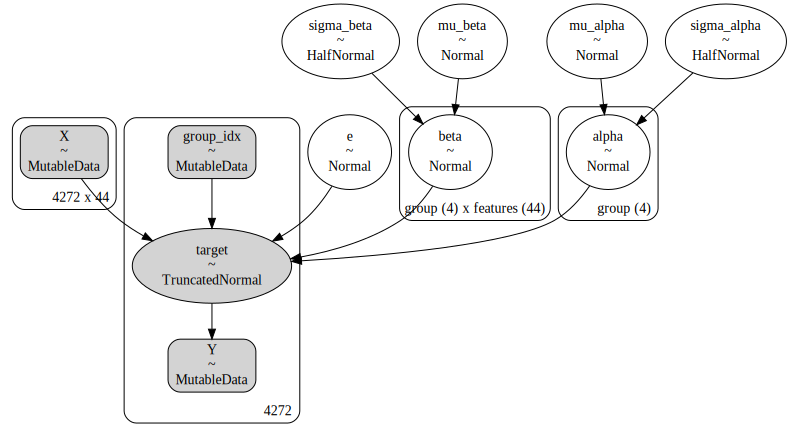

In [62]:
# Defining HBM model

model = pm.Model(coords = coords)

with model:
    X = pm.MutableData("X", X_train_reduced)
    Y = pm.MutableData("Y", Y_train)
    
    group_idx = pm.MutableData("group_idx", g_id)
    mu_alpha = pm.Normal('mu_alpha', mu=10, sigma=10)
    sigma_alpha = pm.HalfNormal('sigma_alpha',5)
    mu_beta = pm.Normal('mu_beta', mu=0.5, sigma=3)
    sigma_beta = pm.HalfNormal('sigma_beta', 3)
    error = pm.Normal('e' , mu = 0, sigma = 10)
    betas = pm.Normal('beta', mu_beta, sigma_beta,dims = ['group',"features"])
    alpha = pm.Normal('alpha' , mu_alpha , sigma_alpha, dims = 'group')

    y = alpha[group_idx] + (betas[group_idx] * X).sum(axis=-1) + error 
    target = pm.TruncatedNormal('target', mu = y,lower=0,upper=1, observed = Y)
    
pm.model_to_graphviz(model)

In [83]:
with model:
    step = pm.NUTS(target_accept = 0.99)
    trace = pm.sample(3000,init='ADVI+adapt_diag',return_inferencedata=True, tune = 1000, step = step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, e, beta, alpha]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 22128 seconds.


                            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_alpha                  26.685  9.812   8.474   45.710      0.970    0.707   
mu_beta                    0.053  0.040  -0.028    0.125      0.002    0.001   
e                         -9.656  9.731 -28.450    8.619      1.036    0.759   
beta[1, CABG_status]       0.693  0.043   0.614    0.777      0.002    0.001   
beta[1, last_hematocrit]  -0.058  0.020  -0.096   -0.019      0.001    0.001   
...                          ...    ...     ...      ...        ...      ...   
alpha[2]                  22.332  9.731   4.802   41.870      1.038    0.765   
alpha[3]                  38.916  9.817  20.406   57.717      1.039    0.762   
alpha[4]                  41.531  9.781  22.837   59.865      1.009    0.742   
sigma_alpha               10.006  2.145   6.320   13.953      0.093    0.066   
sigma_beta                 0.561  0.033   0.503    0.625      0.002    0.001   

                          ess_bulk  ess

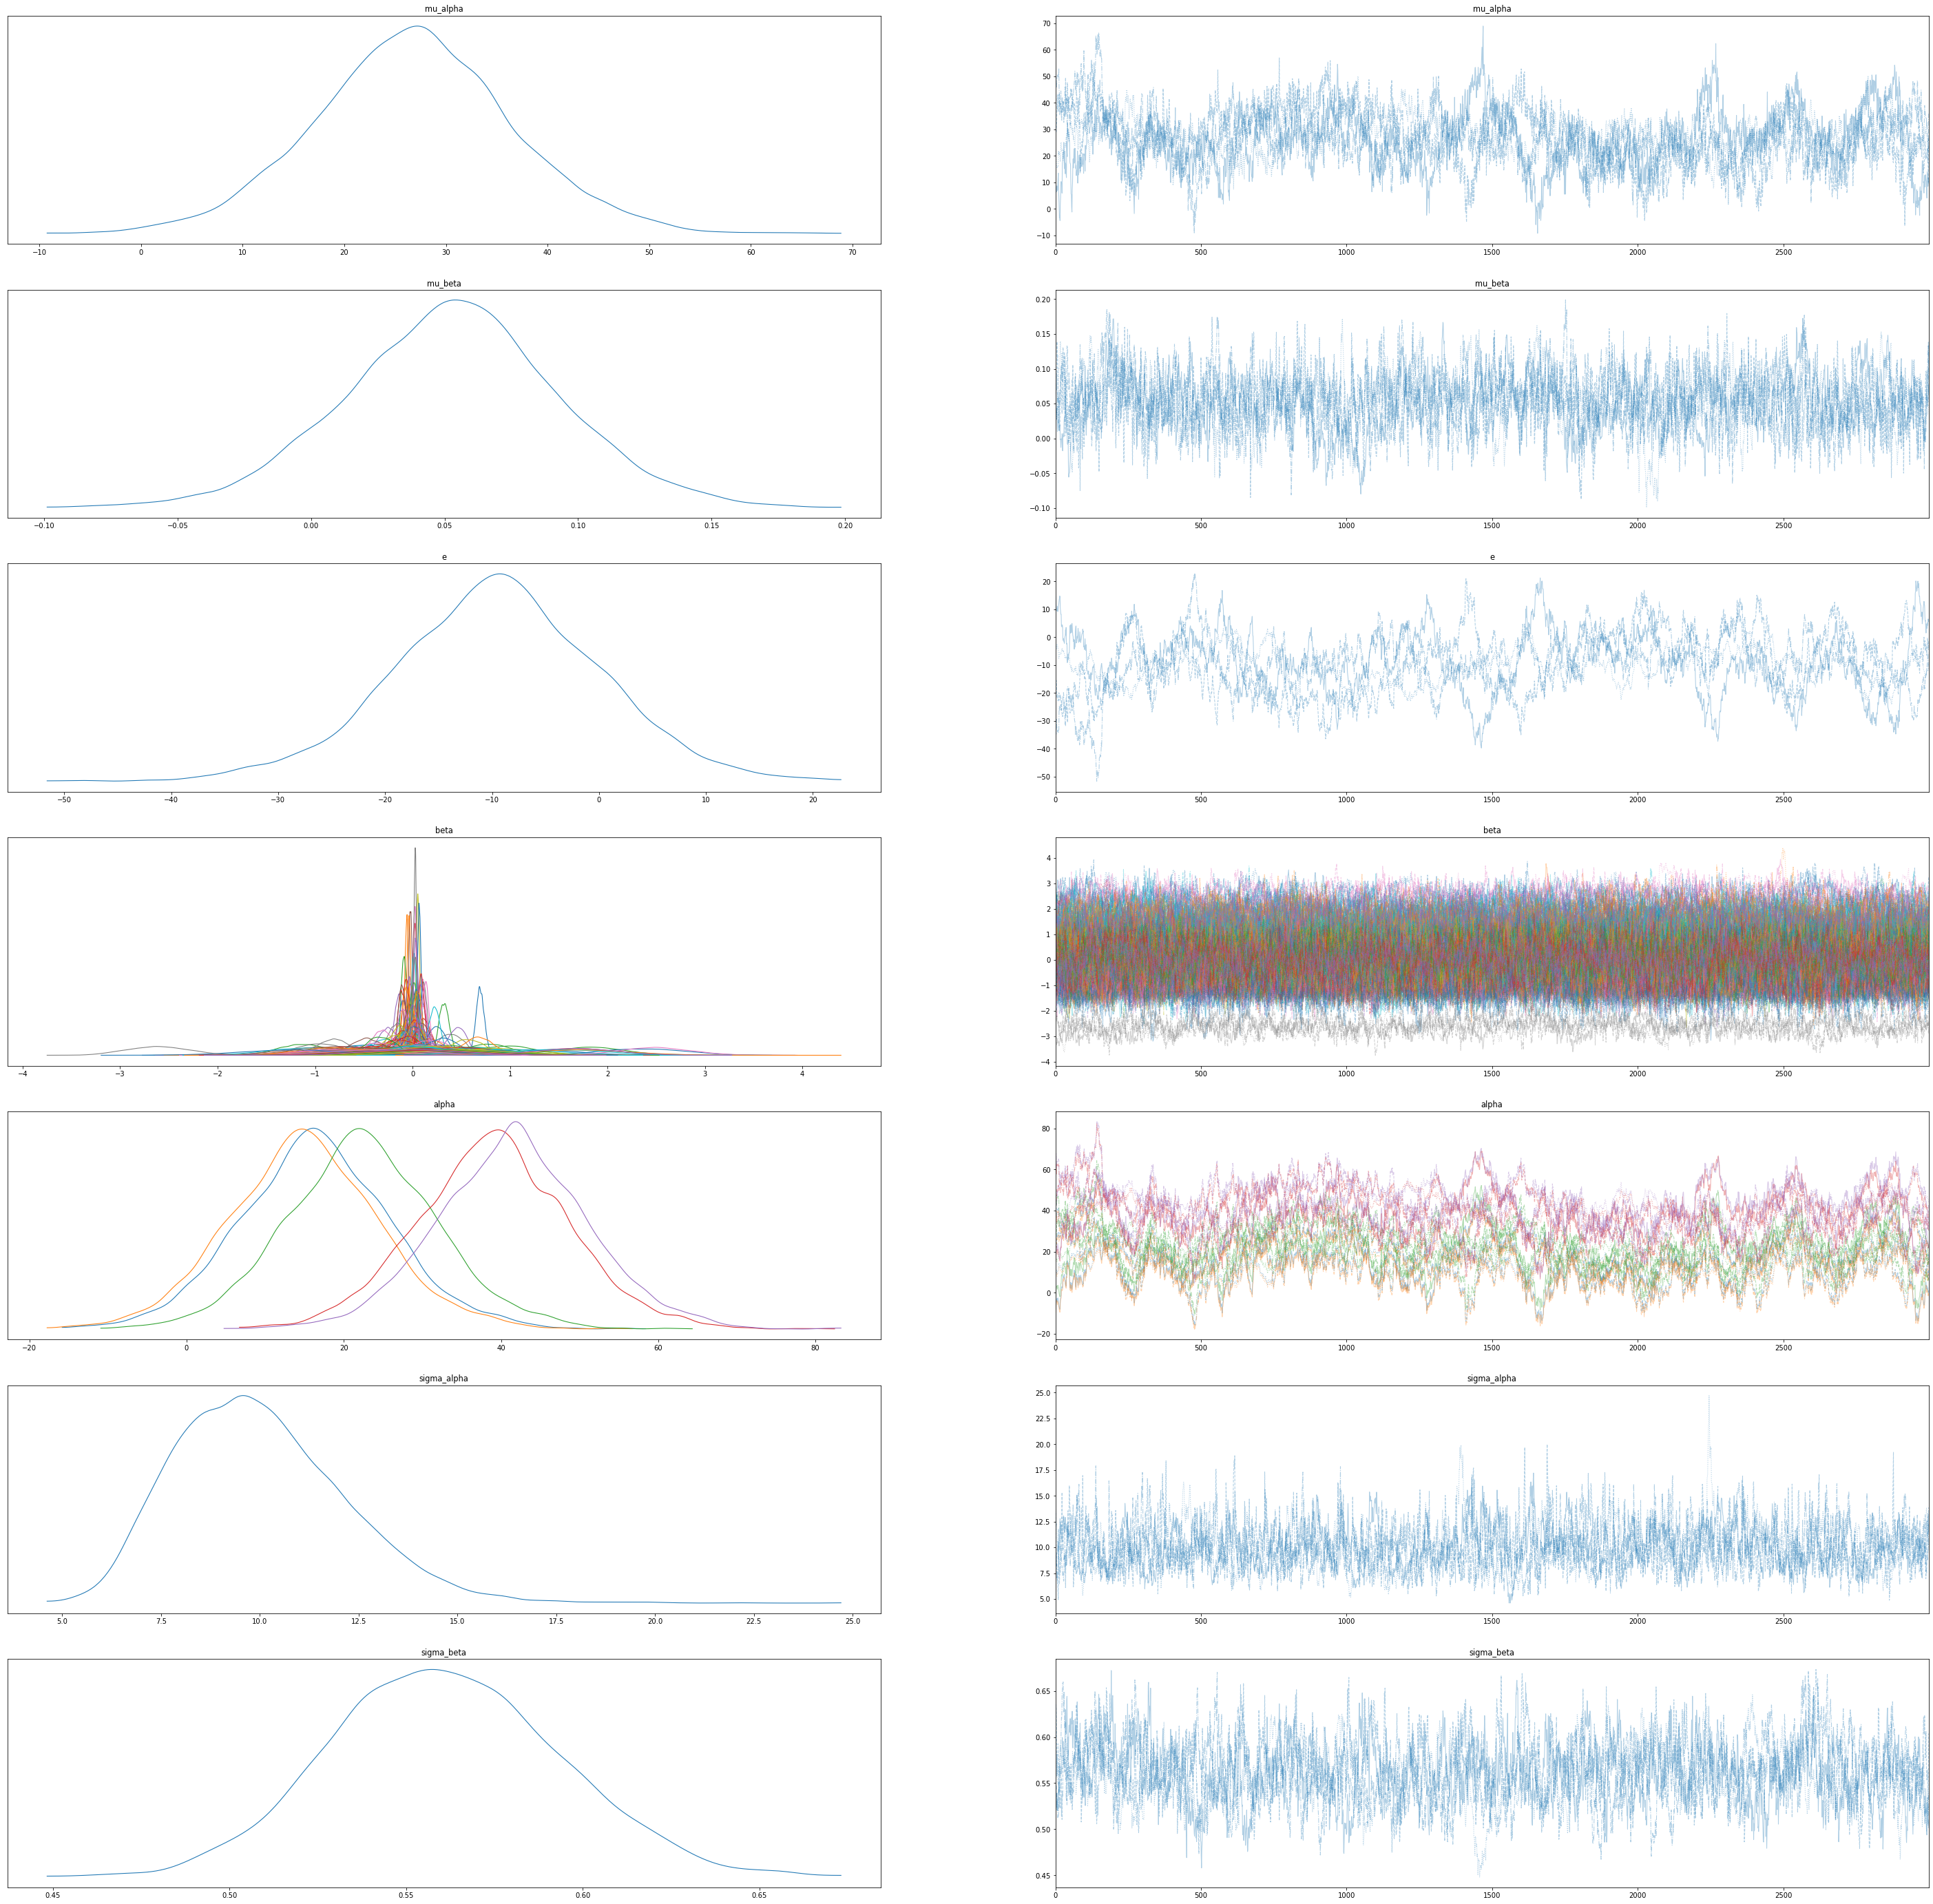

In [66]:
with model:
    arviz.plot_trace(trace, combined = True, figsize = (50,50))
    print(pm.summary(trace))

<AxesSubplot:>

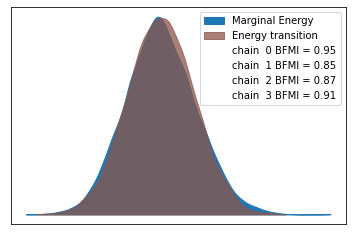

In [64]:
# Energy trace
'''
The energy trace shows that the sampler managed to effectively and efficiently explore the 
marginal distribution. If the plot of energy transition (brown) was narrower than the marginal energy plot (blue)
then the model do not have enough energy to explore the whole parameter space and is likely biased. 

Ref. https://arxiv.org/pdf/1701.02434.pdf
'''
import arviz as az
az.plot_energy(trace)

#### Predictions on testing dataset (sampling from the learned posterior)

In [73]:
# Sampling from the posterior given testing data
with model:
    pm.set_data({"X": X_test_reduced, "Y": Y_test, "group_idx":t_id})
    #trace.posterior_predictive["target"]
    trace.extend(pm.sample_posterior_predictive(trace, var_names = ['target','beta'],random_seed = 70, extend_inferencedata = True))#, sample_dims = ['group'], return_inferencedata=True, predictions=True,  extend_inferencedata=True))

Sampling: [beta, target]


In [80]:
# Unscaling the predictions and the target variable
Y_test_unscaled = Y_test * (maxes_train['LOS'] - mins_train['LOS']) + mins_train['LOS']
predicted = trace.posterior_predictive["target"].mean(dim=["chain", "draw"])
predicted_unscaled = predicted * (maxes_train['LOS'] - mins_train['LOS']) + mins_train['LOS']


In [76]:
# Metrics
from sklearn import metrics
meanAbErr = metrics.mean_absolute_error(Y_test_unscaled, predicted_unscaled)
meanSqErr = metrics.mean_squared_error(Y_test_unscaled, predicted_unscaled)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(Y_test_unscaled, predicted_unscaled))
mean = predicted_unscaled.mean()
std = predicted_unscaled.std()
min = predicted_unscaled.min()
max = predicted_unscaled.max()
cv = std/mean
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)
print('Mean:', mean )
print('STD: ', std)
print('Min:', min)
print('Max:', max)
print('CV:', cv)


Mean Absolute Error: 1.1684852150842067
Mean Square Error: 2.2320217678496084
Root Mean Square Error: 1.4939952368898666
Mean: <xarray.DataArray 'target' ()>
array(8.3258773)
STD:  <xarray.DataArray 'target' ()>
array(3.23160497)
Min: <xarray.DataArray 'target' ()>
array(4.67025941)
Max: <xarray.DataArray 'target' ()>
array(39.79077322)
CV: <xarray.DataArray 'target' ()>
array(0.38813987)


In [82]:
# Some more metrics
rss = pow((predicted_unscaled - Y_test_unscaled['LOS']),2).sum()
tss = pow((Y_test_unscaled['LOS'] - Y_test_unscaled['LOS'].mean()), 2).sum()
rsq = 1-(rss/tss)
print('Rsq: ', rsq*100)
adj_r2 = 1-(1-rsq)* ((Y_test_unscaled.shape[0]-1)/(Y_test_unscaled.shape[0]-X_test.shape[1]-1))
print('Adj Rsq: ', adj_r2*100)


Rsq:  <xarray.DataArray ()>
array(83.33260521)
Adj Rsq:  <xarray.DataArray ()>
array(82.37546769)


#### Saving training and testing data to be used for other models

In [ ]:
X_train_reduced.to_excel('xtrain_1.4.xlsx',index = True)
X_test_reduced.to_excel('xtest_1.4.xlsx',index = True)
Y_train.to_excel('ytrain_1.4.xlsx',index = True)
Y_test.to_excel('ytest_1.4.xlsx',index = True)